# ESP32 CIFAR-10 Test

## Modules

In [1]:
import json
import numpy as np
import os
import serial
from tensorflow.keras.datasets import cifar10
import time

from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

2024-06-03 19:45:16.154398: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-03 19:45:16.160316: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-03 19:45:16.224539: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-03 19:45:17.354847: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## CIFAR-10 Dataset

In [2]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
assert x_train.shape == (50000, 32, 32, 3)
assert x_test.shape == (10000, 32, 32, 3)
assert y_train.shape == (50000, 1)
assert y_test.shape == (10000, 1)

In [3]:
x_train[0]

array([[[ 59,  62,  63],
        [ 43,  46,  45],
        [ 50,  48,  43],
        ...,
        [158, 132, 108],
        [152, 125, 102],
        [148, 124, 103]],

       [[ 16,  20,  20],
        [  0,   0,   0],
        [ 18,   8,   0],
        ...,
        [123,  88,  55],
        [119,  83,  50],
        [122,  87,  57]],

       [[ 25,  24,  21],
        [ 16,   7,   0],
        [ 49,  27,   8],
        ...,
        [118,  84,  50],
        [120,  84,  50],
        [109,  73,  42]],

       ...,

       [[208, 170,  96],
        [201, 153,  34],
        [198, 161,  26],
        ...,
        [160, 133,  70],
        [ 56,  31,   7],
        [ 53,  34,  20]],

       [[180, 139,  96],
        [173, 123,  42],
        [186, 144,  30],
        ...,
        [184, 148,  94],
        [ 97,  62,  34],
        [ 83,  53,  34]],

       [[177, 144, 116],
        [168, 129,  94],
        [179, 142,  87],
        ...,
        [216, 184, 140],
        [151, 118,  84],
        [123,  92,  72]]

## ESP32 MCU Procedures

In [4]:
def init_serial(port_name):
    # Configure and open serial port
    port = serial.Serial(
        port=port_name,
        baudrate=115200,
        bytesize=serial.EIGHTBITS,
        parity=serial.PARITY_NONE,
        stopbits=serial.STOPBITS_ONE,
        xonxoff=False,
        rtscts=False,
        dsrdtr=False
    )
    
    port.reset_input_buffer()
    port.reset_output_buffer()
    return port

In [5]:
def send_to_mcu(port, data):
    bytes_written = port.write(data)
    return bytes_written

In [6]:
def read_result_from_mcu(port):
    line = port.read_until()   # read a '\n' terminated line
    return line

In [7]:
def infer_with_MCU(raw_image):
    img = np.array(raw_image, dtype=np.uint8)
    bytes_sent = send_to_mcu(serial_port, img)
    
    response_str = read_result_from_mcu(serial_port)
    response_str = response_str.decode("utf-8")
    print(response_str)
    predictions = np.fromstring(response_str, dtype=np.float32, sep=',')
    return predictions[:-3], predictions[-3], int(predictions[-2])
    # return None, None

## Serial port setup

In [8]:
# SERIAL_PORT_NAME = '/dev/ttyUSB0'
SERIAL_PORT_NAME = '/dev/ttyUSB1'
# SERIAL_PORT_NAME = '/dev/ttyUSB2'
# SERIAL_PORT_NAME = '/dev/ttyUSB3'
# SERIAL_PORT_NAME = '/dev/ttyUSB4'
# SERIAL_PORT_NAME = '/dev/ttyUSB5'

# Configure and open serial port
serial_port = init_serial(SERIAL_PORT_NAME)

# Check which port was really used
print("Opened serial port : {0}".format(serial_port.name))

Opened serial port : /dev/ttyUSB1


## Predictions

In [9]:
i = 0
# n = 5
n = x_test.shape[0]
right_preds = 0
y_pred_label = []
results = {}
for raw_image in x_test[:n]:
    
    print(f"img {i}")

    while True:
        try:
            result_mcu, inference_time, ret = infer_with_MCU(raw_image)
            # print(result_mcu, inference_time, ret)
            if ret == 0:
                break
        except:
            serial_port.reset_input_buffer()
            serial_port.reset_output_buffer()
            print("wait...")
            time.sleep(3)
            print(f"trying img {i} again")
    
    # print(f"tfl esp32 image({i}) {inference_time/1000}s: y_pred = {np.argmax(result_mcu)} | y_test = {y_test[i][0]} -> {np.argmax(result_mcu) == y_test[i][0]}")
    
    pred_label = np.argmax(result_mcu)
    y_pred_label.append(pred_label)

    if pred_label == y_test[i][0]:
        right_preds += 1

    # dict para o arquivo de dados de teste
    results[str(i)] = {
        "inference_time": float(inference_time/1000),
        "pred_label": int(pred_label),
        "true_label": int(y_test[i][0])
    }

    i += 1

print("General Accuracy: ", right_preds/n)

img 0
0.000000e+00,0.000000e+00,0.000000e+00,9.921875e-01,0.000000e+00,3.906250e-03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.355268e+04,0,

img 1
wait...
trying img 1 again
3.906250e-03,5.078125e-02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,9.492188e-01,0.000000e+00,3.355865e+04,0,

img 2


## Statistics

In [ ]:
y_true_label = np.reshape(y_test[:n], -1)
y_pred_label = np.array(y_pred_label)
print('Classification Report     : \n\n\n' , classification_report(y_true_label, y_pred_label))
# y_true_label, y_pred_label

Classification Report     : 


               precision    recall  f1-score   support

           0       0.89      0.88      0.89      1000
           1       0.93      0.96      0.94      1000
           2       0.81      0.82      0.81      1000
           3       0.71      0.73      0.72      1000
           4       0.83      0.86      0.85      1000
           5       0.83      0.75      0.79      1000
           6       0.86      0.91      0.89      1000
           7       0.90      0.90      0.90      1000
           8       0.93      0.93      0.93      1000
           9       0.95      0.90      0.93      1000

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000



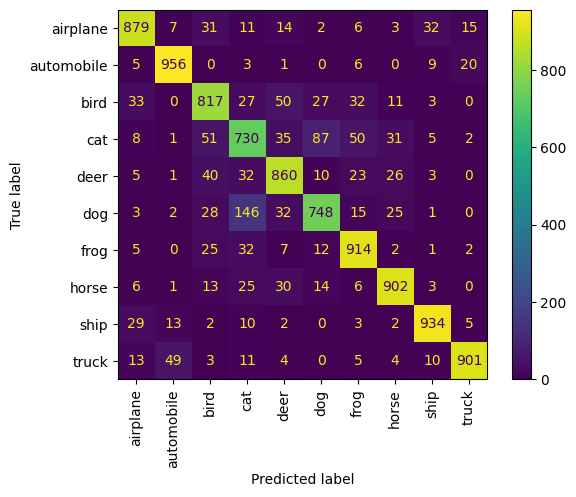

In [ ]:
# print(y_true_label, y_pred_label, np.concatenate((y_true_label, y_pred_label), axis=0))
all_y_labels = np.unique(np.concatenate((y_true_label, y_pred_label), axis=0))
cifar10_labels = [
    "airplane",
    "automobile",
    "bird",
    "cat",
    "deer",
    "dog",
    "frog",
    "horse",
    "ship",
    "truck"
]
cvt_labels = [cifar10_labels[l] for l in all_y_labels]
cm = confusion_matrix(y_true_label, y_pred_label)
cm_display = ConfusionMatrixDisplay(cm, display_labels=cvt_labels)
cm_display.plot(xticks_rotation="vertical")

### Saving statistics

In [ ]:
t_write = time.strftime("%Y%m%d-%H%M%S")
dir_path = f'./results/res-{t_write}/'
if not os.path.exists(dir_path):
    os.makedirs(dir_path)

c_report = classification_report(y_true_label, y_pred_label, output_dict=True)
c_report_path = os.path.join(dir_path, f'creport-{t_write}.json')
with open(c_report_path, "w") as c_report_file:
    json.dump(c_report, c_report_file, indent=4)

In [ ]:
results_path = os.path.join(dir_path, f'results-{t_write}.json')
with open(results_path, "w") as results_file:
    json.dump(results, results_file, indent=4)

In [ ]:
cm_path = os.path.join(dir_path, f'cmatrix-{t_write}.png')
cm_display.figure_.savefig(cm_path, bbox_inches="tight")